Links:

- https://surprise.readthedocs.io/en/stable/getting_started.html
- https://surpriselib.com/

Inspiration:
- https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
- https://github.com/rposhala/Recommender-System-on-MovieLens-dataset
- https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb
- https://www.kaggle.com/code/sunyuanxi/surprise
- https://surprise.readthedocs.io/en/stable/FAQ.html
- https://surprise.readthedocs.io/en/stable/predictions_module.html
- https://github.com/rposhala/Recommender-System-on-MovieLens-dataset
- https://nbviewer.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb
- https://towardsdatascience.com/how-you-can-build-simple-recommender-systems-with-surprise-b0d32a8e4802


State of the art:
- https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k

In [2]:
import numpy as np
import pandas as pd

In [3]:
RATINGS_DATA_FILE = './ml-100k/u.data'
USERS_DATA_FILE = './ml-100k/u.user'

ratings = pd.read_csv(RATINGS_DATA_FILE, sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
users = pd.read_csv(USERS_DATA_FILE, sep='|', header=None, names=['user id', 'age', 'gender', 'occupation', 'zip code']) #encoding='ISO-8859-1'
movies = pd.read_csv('ml-100k/u.item', 
                    sep='|', 
                    header=None, 
                    encoding='ISO-8859-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 
                    'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
del movies['video_release_date']
del movies['unknown']
del movies['IMDb_URL']

In [4]:
ratings_dict = {'userID': list(ratings.user_id),
                'itemID': list(ratings.item_id),
                'rating': list(ratings.rating),
                'timestand' : list(ratings.timestamp)}

df = pd.DataFrame(ratings_dict)
print(df.shape)
display(df)
print(users.shape)
display(users.head(10))

(100000, 4)


,userID,itemID,rating,timestand
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


(943, 5)


,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


# Exploratory Data Analysis (EDA)

As to better understand the data we're working with, EDA will be performed. This will include distribution of the ratings and the user's ratings.

In [5]:
from plotly.offline import iplot
import plotly.graph_objs as go

data = df['rating'].value_counts()#.sort_index(ascending=False)
print(data)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               y = data.values,
               )


# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64


In [6]:
# display(df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False).head(10))
data = df.groupby('itemID')['rating'].count().clip().sort_values(ascending=False)
display(data)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 600, #Max is 583
                                  size = 20))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Item',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

itemID
50      583
258     509
100     508
181     507
294     485
       ... 
1576      1
1577      1
1348      1
1579      1
1682      1
Name: rating, Length: 1682, dtype: int64

In [7]:
data = df.groupby('itemID')['rating'].agg('mean').sort_values(ascending=False)
display(data.head(15))

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(#start = 0.0,
                                  #end = 5.0,
                                  size = 0.1))
# Create layout
layout = go.Layout(title = 'Distribution of average rating of items',
                   xaxis = dict(title = 'Mean rating of item'),
                   yaxis = dict(title = 'Count/number of items'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

itemID
814     5.000
1599    5.000
1201    5.000
1122    5.000
1653    5.000
1293    5.000
1500    5.000
1189    5.000
1536    5.000
1467    5.000
1449    4.625
119     4.500
1398    4.500
1642    4.500
1594    4.500
Name: rating, dtype: float64

In [8]:
data = df.groupby('userID')['rating'].agg('mean').sort_values(ascending=False)
display(data.head(10))

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(#start = 0.0,
                                  #end = 5.0,
                                  size = 0.1))
# Create layout
layout = go.Layout(title = 'Distribution of average rating by users',
                   xaxis = dict(title = 'Mean rating by user'),
                   yaxis = dict(title = 'Count/number of users'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

userID
849    4.869565
688    4.833333
507    4.724138
628    4.703704
928    4.687500
118    4.661972
907    4.571429
686    4.563380
427    4.548387
565    4.542857
Name: rating, dtype: float64

In [9]:
display(df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False))

,userID,rating
404,405,737
654,655,685
12,13,636
449,450,540
275,276,518
...,...,...
684,685,20
474,475,20
35,36,20
731,732,20


Analysis based on the EDA can be found in the report.

# Creating a model using suprise

For this the Suprise library is used. Suprise is a python scikit made specifically for recommender systems, and it includes a variety of prediction algorithms (using collaborative methods). First, we will test the different algorithms (by cross-validating) and find the one who gives the least Root-Mean-Square-Error (RMSE).

In [10]:
from surprise import NormalPredictor, SVD, KNNBasic, NMF
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, KFold


from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise.model_selection import train_test_split

reader = Reader(line_format='user item rating timestamp', sep='\t')
reader = Reader(rating_scale=(1.0, 5.0))

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.926785,17.159596,6.733058
KNNBaseline,0.936582,0.387339,6.667382
SVD,0.944588,1.722145,0.540839
BaselineOnly,0.947630,0.102988,0.274377
SlopeOne,0.948573,0.436195,4.273286
KNNWithMeans,0.956960,0.333620,5.844114
KNNWithZScore,0.956965,0.366060,6.451483
NMF,0.977316,1.703451,0.315504
KNNBasic,0.988572,0.314251,5.483605


We see that SVDpp provides the best RMSE values, therefore we will continue with that. Though it does have a long fit and test time, it is not significant to chose another algorithm.

In [21]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVDpp()


predictions = algo.fit(trainset).test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.9257
0.9257303251983675


In [33]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
# df_predictions1.head()
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [25]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
19384,628,300,5.0,5.0,{'was_impossible': False},18,335,0.0
16802,416,144,5.0,5.0,{'was_impossible': False},404,195,0.0
12135,592,238,5.0,5.0,{'was_impossible': False},288,209,0.0
11996,264,56,5.0,5.0,{'was_impossible': False},96,322,0.0
18649,348,313,5.0,5.0,{'was_impossible': False},42,285,0.0
11903,537,539,1.0,1.0,{'was_impossible': False},385,33,0.0
8394,851,172,5.0,5.0,{'was_impossible': False},164,305,0.0
18662,774,758,1.0,1.0,{'was_impossible': False},179,15,0.0
17761,405,669,1.0,1.0,{'was_impossible': False},599,9,0.0
11842,200,50,5.0,5.0,{'was_impossible': False},165,458,0.0


In [26]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
8831,314,70,1.0,4.399133,{'was_impossible': False},198,203,3.399133
19801,167,169,1.0,4.407055,{'was_impossible': False},59,90,3.407055
15963,295,96,1.0,4.464123,{'was_impossible': False},150,231,3.464123
4897,777,100,1.0,4.464446,{'was_impossible': False},27,387,3.464446
16173,239,318,1.0,4.478511,{'was_impossible': False},131,249,3.478511
6585,934,216,1.0,4.484552,{'was_impossible': False},141,245,3.484552
7307,405,238,5.0,1.494252,{'was_impossible': False},599,209,3.505748
4157,286,421,1.0,4.587740,{'was_impossible': False},233,85,3.587740
3658,314,173,1.0,4.704296,{'was_impossible': False},198,254,3.704296
7980,405,376,5.0,1.000000,{'was_impossible': False},599,19,4.000000


The best predictions seems well off (and not lucky guesses, as many users have rated the given movies, as indicated by the Ui column), but some of the worst predictions will need more investigation.

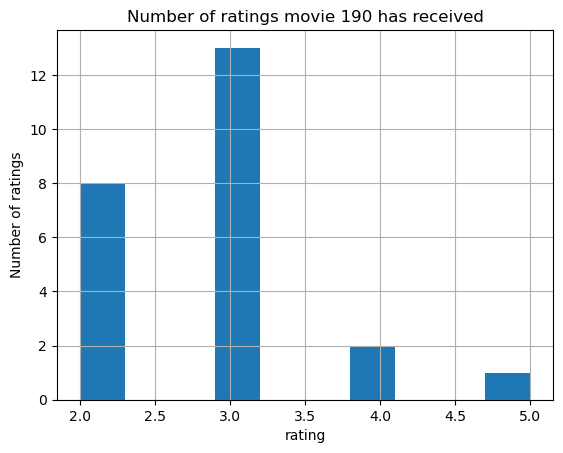

In [31]:
import matplotlib.pyplot as plt
df.loc[df['itemID'] == 376]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie 190 has received')
plt.show()

It seems as if the user, who rated the movie a 5, is a bit of an outlier. With this in mind, it makes sense that our model predicted a score of 1. Let's check the next worst prediction

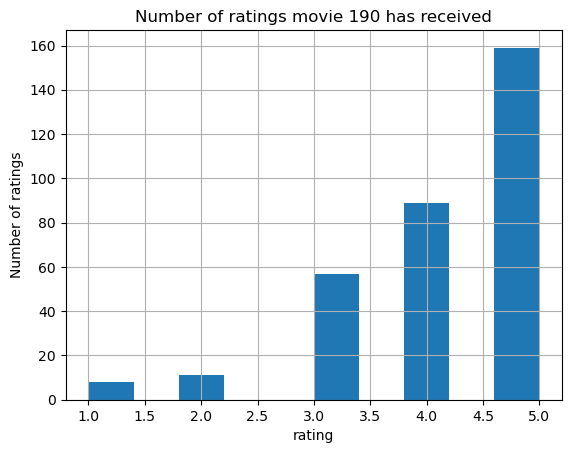

In [91]:
import matplotlib.pyplot as plt
df.loc[df['itemID'] == 173]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie 190 has received')
plt.show()

Once again, it seems as if the user's score is an outlier (most rated it highly, except for user 314, which rated it very low). With these two examples in mind, as well as the model having RMSE of 0.9257, we're content with the result of the model. Now we're ready to recommend some movies!

In [105]:
import difflib
import random

def get_movie_id(movie_title, metadata):
    existing_titles = list(metadata['movie_title'].values)
    closest_titles = difflib.get_close_matches(movie_title, existing_titles)
    movie_id = metadata[metadata['movie_title'] == closest_titles[0]]['movie_id'].values[0]
    return movie_id

def get_movie_info(movie_id, metadata):
    movie_info = metadata[metadata['movie_id'] == movie_id]
    movie_info = movie_info.loc[:, (movie_info != 0).any(axis=0)]
    return movie_info.to_dict(orient='records')[0]

def predict_review(user_id, movie_title, model, metadata):
    
    movie_id = get_movie_id(movie_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=movie_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=4):
    
    movie_titles = list(metadata['movie_title'].values)
    random.shuffle(movie_titles)
    movie_list = []

    for movie_title in movie_titles:
        rating = predict_review(user_id, movie_title, model, metadata)
        if rating >= thresh:
            movie_id = get_movie_id(movie_title, metadata)
            movie_list.append(get_movie_info(movie_id, metadata))
        if(len(movie_list) == 5):
            return movie_list

reccomendation = generate_recommendation(200, algo, movies, thresh=4)
reccomendation

[{'movie_id': 267, 'movie_title': 'unknown', 'release_date': nan},
 {'movie_id': 22,
  'movie_title': 'Braveheart (1995)',
  'release_date': '16-Feb-1996',
  'Action': 1,
  'Drama': 1,
  'War': 1},
 {'movie_id': 223,
  'movie_title': 'Sling Blade (1996)',
  'release_date': '22-Nov-1996',
  'Drama': 1,
  'Thriller': 1},
 {'movie_id': 1251,
  'movie_title': 'A Chef in Love (1996)',
  'release_date': '25-Apr-1997',
  'Comedy': 1},
 {'movie_id': 182,
  'movie_title': 'GoodFellas (1990)',
  'release_date': '01-Jan-1990',
  'Crime': 1,
  'Drama': 1}]

Finally, check if these movies are in the same genres as the ones the user usually watches.

In [104]:
user_200_ratings = df[df['userID'] == 200].sort_values(by='rating', ascending=False)
display(user_200_ratings)
user_200_ratings_ids = user_200_ratings['itemID']

user_200_movies = movies[movies['movie_id'].isin(user_200_ratings_ids)][:5]
user_200_movies.loc[:, (user_200_movies != 0).any(axis=0)]

,userID,itemID,rating,timestand
12,200,222,5,876042340
41852,200,385,5,884129696
14772,200,228,5,884128372
34329,200,568,5,884128372
36065,200,423,5,884129275
...,...,...,...,...
39472,200,48,2,884129029
31396,200,401,2,884130085
3684,200,409,2,884127431
27523,200,982,2,891825589


,movie_id,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Drama,Sci-Fi,Thriller
0,1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,1
6,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,1,1,0
7,8,Babe (1995),01-Jan-1995,0,0,0,1,1,1,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,0,0,0,0,0,1,0,0
